# Latent Dirichlet Allocation(LDA)

### A statistical model for discovering the abstract topics aka topic modeling.

Topic modeling is a method for unsupervised classification of documents, similar to clustering on numeric data, which finds some natural groups of items (topics) even when we’re not sure what we’re looking for.

The aim of LDA is to find topics a document belongs to, based on the words in it.Confused much? Here is an example to walk you through it.

<br />
<center>
<img src="LDA.webp" width=700 />
</center>

We have 5 documents each containing the words listed in front of them( ordered by frequency of occurrence).

What we want to figure out are the words in different topics, as shown in the table below. Each row in the table represents a different topic and each column a different word in the corpus. Each cell contains the probability that the word(column) belongs to the topic(row).

<br />
<center>
<img src="LDA2.webp" width=700 />
</center>

#### Finding Representative Words for a Topic

We can sort the words with respect to their probability score.

The top x words are chosen from each topic to represent the topic. If x = 10, we’ll sort all the words in topic1 based on their score and take the top 10 words to represent the topic.
This step may not always be necessary because if the corpus is small we can store all the words in sorted by their score.
Alternatively, we can set a threshold on the score. All the words in a topic having a score above the threshold can be stored as its representative, in order of their scores.


In [1]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
     
# spacy for lemmatization
import spacy

In [2]:
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
with open('Othello.txt') as f:
    lines = f.readlines();
lines

['ï»¿Othello, the Moore of Venice\n',
 'ACT I\n',
 'SCENE I. Venice. A street.\n',
 '\n',
 'Enter RODERIGO and IAGO\n',
 'RODERIGO\n',
 'Tush! never tell me; I take it much unkindly\n',
 'That thou, Iago, who hast had my purse\n',
 'As if the strings were thine, shouldst know of this.\n',
 'IAGO\n',
 "'Sblood, but you will not hear me:\n",
 'If ever I did dream of such a matter, Abhor me.\n',
 'RODERIGO\n',
 "Thou told'st me thou didst hold him in thy hate.\n",
 'IAGO\n',
 'Despise me, if I do not. Three great ones of the city,\n',
 'In personal suit to make me his lieutenant,\n',
 "Off-capp'd to him: and, by the faith of man,\n",
 'I know my price, I am worth no worse a place:\n',
 'But he; as loving his own pride and purposes,\n',
 'Evades them, with a bombast circumstance\n',
 "Horribly stuff'd with epithets of war;\n",
 'And, in conclusion,\n',
 "Nonsuits my mediators; for, 'Certes,' says he,\n",
 "'I have already chose my officer.'\n",
 'And what was he?\n',
 'Forsooth, a great ar

In [4]:
import re
def eda(lines):
    processed_sentences = []

    for s in lines:
        # Remove all the special characters
        processed_sentence = re.sub(r'\W', ' ', str(s))

        # remove all single characters
        processed_sentence= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_sentence)

        # Remove single characters from the start
        processed_sentence = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_sentence) 

        # Substituting multiple spaces with single space
        processed_sentence = re.sub(r'\s+', ' ', processed_sentence, flags=re.I)

        # Removing prefixed 'b'
        processed_sentence = re.sub(r'^b\s+', '', processed_sentence)

        # Converting to Lowercase
        processed_sentence = processed_sentence.lower()

        processed_sentences.append(processed_sentence)
        
        return processed_sentences

In [5]:
processed_sentences = eda(lines)

In [6]:
def sent_to_words(processed_sentences):
    for  processed_sentences in  processed_sentences:
        yield(gensim.utils.simple_preprocess(str(processed_sentences), deacc=True))  # deacc=True removes punctuations

mao_words = list(sent_to_words(lines))

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(mao_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[mao_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[mao_words[11]]])

['if', 'ever', 'did', 'dream', 'of', 'such', 'matter', 'abhor', 'me']


In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
import spacy

In [10]:
spacy.cli.download('en_core_web_sm')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [11]:

import en_core_web_sm
nlp = en_core_web_sm.load()

In [12]:
!pip install gensim==3.8.3

In [13]:
!pip install pyLDAvis==3.3.1

In [14]:
# Remove Stop Words
mao_words_nostops = remove_stopwords(mao_words)

# Form Bigrams
mao_words_bigrams = make_bigrams(mao_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
mao_lemmatized = lemmatization(mao_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(mao_lemmatized[:11])

[['venice'], [], ['scene', 'street'], [], ['enter', 'roderigo', 'iago'], [], ['tush', 'never', 'tell', 'take', 'much', 'unkindly'], ['hast', 'purse'], ['string', 'shouldst', 'know'], ['iago'], ['hear']]


In [15]:
# Create Dictionary
id2word = corpora.Dictionary(mao_lemmatized)

# Create Corpus
texts = mao_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:11])

[[(0, 1)], [], [(1, 1), (2, 1)], [], [(3, 1), (4, 1), (5, 1)], [], [(6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)], [(12, 1), (13, 1)], [(14, 1), (15, 1), (16, 1)], [(4, 1)], [(17, 1)]]


In [16]:
id2word[12]

'hast'

In [17]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:7]]

[[('venice', 1)],
 [],
 [('scene', 1), ('street', 1)],
 [],
 [('enter', 1), ('iago', 1), ('roderigo', 1)],
 [],
 [('much', 1),
  ('never', 1),
  ('take', 1),
  ('tell', 1),
  ('tush', 1),
  ('unkindly', 1)]]

In [18]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [19]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.110*"fortune" + 0.095*"seem" + 0.057*"hast" + 0.033*"full" + '
  '0.031*"practise" + 0.004*"purse" + 0.000*"find" + 0.000*"seize" + '
  '0.000*"pocket" + 0.000*"give"'),
 (1,
  '0.133*"soul" + 0.120*"time" + 0.103*"honest" + 0.083*"much" + 0.059*"sure" '
  '+ 0.017*"master" + 0.013*"knave" + 0.000*"hath" + 0.000*"lie" + '
  '0.000*"torture"'),
 (2,
  '0.647*"iago" + 0.020*"purpose" + 0.001*"conclusion" + 0.000*"wound" + '
  '0.000*"special" + 0.000*"dead" + 0.000*"come" + 0.000*"hurt" + 0.000*"well" '
  '+ 0.000*"othello"'),
 (3,
  '0.136*"matter" + 0.101*"ever" + 0.085*"place" + 0.051*"bad" + '
  '0.012*"second" + 0.003*"dream" + 0.000*"enforce" + 0.000*"torture" + '
  '0.000*"get" + 0.000*"whipster"'),
 (4,
  '0.023*"truly" + 0.021*"form" + 0.015*"follow" + 0.006*"war" + '
  '0.002*"visage" + 0.000*"delighted" + 0.000*"enjoy" + 0.000*"next" + '
  '0.000*"obedient" + 0.000*"lady"'),
 (5,
  '0.076*"first" + 0.062*"stand" + 0.000*"hand" + 0.000*"give" + 0.000*"come" '
  '+ 0.0

In [20]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=mao_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -24.18692409344425

Coherence Score:  0.5924200900401944


In [21]:
import pyLDAvis
import warnings
import pyLDAvis.gensim_models as gensimvis

vis = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)
pyLDAvis.save_html(vis, './op.html')
# warnings.filterwarnings('ignore')
# vis

C:\Users\cyrus\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [22]:
%pwd

'C:\\Users\\cyrus\\Desktop\\dsProject'

In [27]:
from gensim import models
from gensim.corpora import Dictionary
from gensim import corpora
from gensim import models
from gensim.models import LdaModel
from gensim.models import TfidfModel
import os

os.environ.update({'MALLET_HOME':r'C:\\Users\\cyrus\\Desktop\\dsProject\\mallet-2.0.8'})
# os.environ['MALLET_HOME'] = 'C:\\Users\\cyrus\\Desktop\\ds project\\mallet-2.0.8'

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
#     mallet_path='C:/Users/cyrus/mallet-2.0.8/mallet-2.0.8/bin/mallet'
    mallet_path='C:\\Users\\cyrus\\Desktop\\dsProject\\mallet-2.0.8\\bin\\mallet.bat'
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [28]:
# def compute_coherence_values(corpus, dictionary, k, a, b):
    
#     lda_model = gensim.models.LdaMulticore(corpus=corpus,
#                                            id2word=dictionary,
#                                            num_topics=k, 
#                                            random_state=100,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha=a,
#                                            eta=b)
    
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=mao_lemmatized, dictionary=id2word, coherence='c_v')
    
#     return coherence_model_lda.get_coherence()

In [30]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(corpus=corpus, dictionary=id2word, texts=mao_lemmatized, 
                                                        start=2, limit=40, step=6)
print("23")

23


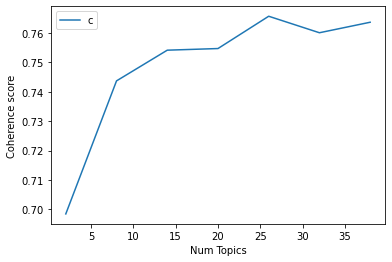

In [34]:
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [35]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.075*"soul" + 0.071*"lie" + 0.049*"sweet" + 0.036*"find" + 0.032*"poor" + '
  '0.032*"bear" + 0.030*"lose" + 0.028*"wife" + 0.021*"prove" + '
  '0.019*"command"'),
 (1,
  '0.066*"heart" + 0.051*"thou" + 0.041*"honest" + 0.041*"art" + 0.032*"dead" '
  '+ 0.030*"show" + 0.023*"suit" + 0.021*"sail" + 0.019*"strike" + '
  '0.017*"thief"'),
 (2,
  '0.186*"love" + 0.048*"roderigo" + 0.043*"faith" + 0.041*"friend" + '
  '0.032*"damn" + 0.032*"foul" + 0.030*"money" + 0.017*"begin" + '
  '0.015*"offence" + 0.013*"marry"'),
 (3,
  '0.131*"iago" + 0.109*"give" + 0.064*"hand" + 0.054*"wife" + 0.043*"nature" '
  '+ 0.026*"father" + 0.021*"jealous" + 0.021*"reputation" + 0.019*"meet" + '
  '0.019*"farewell"'),
 (4,
  '0.060*"kill" + 0.054*"leave" + 0.050*"fall" + 0.050*"handkerchief" + '
  '0.050*"find" + 0.028*"hast" + 0.024*"clown" + 0.022*"sing" + 0.022*"turn" + '
  '0.022*"weep"'),
 (5,
  '0.126*"speak" + 0.087*"hath" + 0.055*"make" + 0.045*"husband" + '
  '0.041*"fear" + 0.036*"murder"

In [39]:
import pandas as pd
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=lines):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=lines)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

C:\Users\cyrus\AppData\Local\Temp\ipykernel_2992\798208346.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\cyrus\AppData\Local\Temp\ipykernel_2992\798208346.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,19,0.0686,"cassio, venice, life, fool, officer, abuse, de...","ï»¿Othello, the Moore of Venice\n"
1,1,0,0.0500,"soul, lie, sweet, find, poor, bear, lose, wife...",ACT I\n
2,2,17,0.0823,"enter, gratiano, general, woman, moor, state, ...",SCENE I. Venice. A street.\n
3,3,0,0.0500,"soul, lie, sweet, find, poor, bear, lose, wife...",\n
4,4,2,0.0660,"love, roderigo, faith, friend, damn, foul, mon...",Enter RODERIGO and IAGO\n
5,5,0,0.0500,"soul, lie, sweet, find, poor, bear, lose, wife...",RODERIGO\n
6,6,19,0.0652,"cassio, venice, life, fool, officer, abuse, de...",Tush! never tell me; I take it much unkindly\n
7,7,4,0.0673,"kill, leave, fall, handkerchief, find, hast, c...","That thou, Iago, who hast had my purse\n"
8,8,17,0.0652,"enter, gratiano, general, woman, moor, state, ...","As if the strings were thine, shouldst know of..."
9,9,11,0.0621,"iago, exit, place, thing, live, bed, full, hea...",IAGO\n


In [ ]:
# from gensim.test.utils import common_corpus, common_dictionary
# from gensim.models.wrappers import LdaMallet
# path_to_mallet_binary = "/path/to/mallet/binary"
# model = LdaMallet(path_to_mallet_binary, corpus=common_corpus, num_topics=20, id2word=common_dictionary)
# vector = model[common_corpus[0]]  # LDA topics of a documents

In [40]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.1038,"soul, lie, sweet, find, poor, bear, lose, wife...","I'll see before I doubt; when I doubt, prove;\n"
1,1,0.0957,"heart, thou, honest, art, dead, show, suit, sa...","A cry within 'A sail, a sail, a sail!'\n"
2,2,0.0980,"love, roderigo, faith, friend, damn, foul, mon...","Alas, poor rogue! I think, i' faith, she loves..."
3,3,0.1019,"iago, give, hand, wife, nature, father, jealou...","Reputation, reputation, reputation! O, I have ..."
4,4,0.0854,"kill, leave, fall, handkerchief, find, hast, c...","And turn again; and she can weep, sir, weep;\n"


In [41]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,19,"cassio, venice, life, fool, officer, abuse, de...",922.0,0.1858
1,0,"soul, lie, sweet, find, poor, bear, lose, wife...",219.0,0.0441
2,17,"enter, gratiano, general, woman, moor, state, ...",241.0,0.0486
3,0,"soul, lie, sweet, find, poor, bear, lose, wife...",233.0,0.0469
4,2,"love, roderigo, faith, friend, damn, foul, mon...",235.0,0.0474
...,...,...,...,...
4958,17,"enter, gratiano, general, woman, moor, state, ...",NaN,NaN
4959,5,"speak, hath, make, husband, fear, murder, part...",NaN,NaN
4960,13,"iago, sir, word, confess, ay, bad, nay, hope, ...",NaN,NaN
4961,0,"soul, lie, sweet, find, poor, bear, lose, wife...",NaN,NaN
